# Eduardo Wanderley

In [41]:
pip install numpy pandas scikit-learn xgboost matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Eduardo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [42]:
pip install RandomForestRegressor

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement RandomForestRegressor (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Eduardo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for RandomForestRegressor


#Steps for Model Uncertainty
- Load and prepare the breast cancer dataset.
- Train the model pool (Random Forest, Logistic Regression, and XGBoost).
- Calculate the uncertainty per instance using entropy.
- Estimate the random and epistemological uncertainties.
- Perform an exploratory analysis with graphs and the surrogate model.

In [43]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns


# Load the Breast Cancer dataset

In [44]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)


# Separate into training and testing.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Selected models

In [46]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Training models and calculating probabilities

In [47]:
# Train the models and calculate prediction probabilities for each model
# Here, we are training three different models (Random Forest, Logistic Regression, and XGBoost)
# and calculating the probabilities predicted by each for the test set (X_test).
probs = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Training each model with the training data
    probs[name] = model.predict_proba(X_test)  # Calculating the predicted probability for each model.


C:\Users\Eduardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [14:39:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Function to calculate entropy

In [48]:
# This function receives the predicted probabilities and calculates the entropy, which is a measure of uncertainty.
import numpy as np

def calc_entropy(probs):
    return -np.sum(probs * np.log(probs), axis=1)   # Formula for entropy



# Calculating the entropy for each instance

In [49]:
# Here, we are applying the entropy function to each model and storing the values.
entropy = {name: calc_entropy(probs[name]) for name in probs}

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1308\2730432941.py:5: RuntimeWarning: divide by zero encountered in log
  return -np.sum(probs * np.log(probs), axis=1)   # Formula for entropy
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1308\2730432941.py:5: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(probs * np.log(probs), axis=1)   # Formula for entropy


# Random uncertainty (average of uncertainties)

In [50]:
# Calculating the epistemological uncertainty, which is the variance of entropies between the models for each instance.
mean_uncertainty = np.mean(list(entropy.values()), axis=0)

# Epistemological uncertainty (variance of uncertainties)

In [51]:
# Calculating the epistemological uncertainty, which is the variance of entropies between the models for each instance.
variance_uncertainty = np.var(list(entropy.values()), axis=0)

# (a) Scatter plot colored by uncertainty

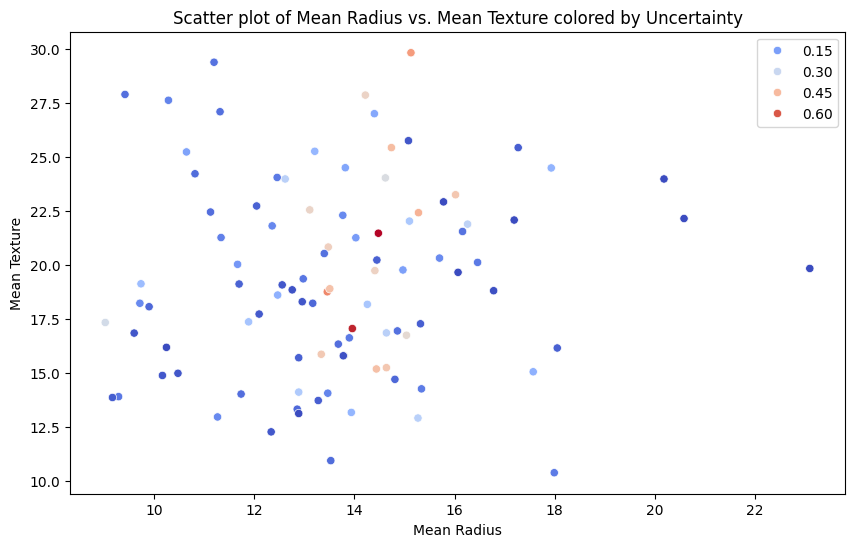

In [52]:
# Generating a scatter plot between 'Mean Radius' and 'Mean Texture', colored by the average uncertainty.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['mean radius'], y=X_test['mean texture'], hue=mean_uncertainty, palette='coolwarm')
plt.title('Scatter plot of Mean Radius vs. Mean Texture colored by Uncertainty')
plt.xlabel('Mean Radius')
plt.ylabel('Mean Texture')
plt.show()

# Using Breast Cancer features to predict average uncertainty

In [53]:
# Remove instances with NaN in mean_uncertainty and X_test.
valid_indices = ~np.isnan(mean_uncertainty)
X_test_valid = X_test[valid_indices]
mean_uncertainty_valid = mean_uncertainty[valid_indices]

# Train the surrogate model using only valid data
surrogate = RandomForestRegressor()
surrogate.fit(X_test_valid, mean_uncertainty_valid)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
from sklearn.ensemble import RandomForestRegressor

surrogate = RandomForestRegressor()
surrogate.fit(X_test_valid, mean_uncertainty_valid)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Predictions of the surrogated model

In [55]:
# Making predictions on the valid set
pred_uncertainty = surrogate.predict(X_test_valid)

# Evaluating the surrogate model by comparing the predicted uncertainty with the actual uncertainty.
# Here, we use the accuracy_score function to check how accurate the model's predictions are.
print(f'Surrogate model accuracy: {accuracy_score(np.round(mean_uncertainty_valid), np.round(pred_uncertainty))}')


Surrogate model accuracy: 0.979381443298969
